### Similarity Index 

1. deblur the generated images[done]

2. compute the simlarity index with cosine similarity [done]

3. convert cosine similarity to pseudo arousal index [done]

4. convert this pseudo arouasl index to tau value for label relaxtion [done]

5. making the label relaxtion dataset, i.e., y_label_relaxed [done]

6. Making the criterion for relaxation and emotion-focal loss [ongoing]
    


In [1]:
### loading the dataset and generated face

import numpy as np

X_train = np.load('X_train_Fer2013.npy')
y_train = np.load('y_train_Fer2013.npy')

X_gen = np.load('evae_conditional_fer2013_sample_neutral_sample_neutral_a=0_v1.npy')

In [3]:
print X_gen.shape

(32298, 48, 48, 1)


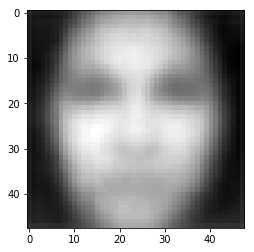

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow((X_gen[14]).reshape((48,48)), cmap ='gray')

In [5]:
### CV deblur helps 

import cv2

trans_img_dataset = cv2.pow(X_gen, 2.9)

In [6]:
print trans_img_dataset.shape

(32298, 48, 48, 1)


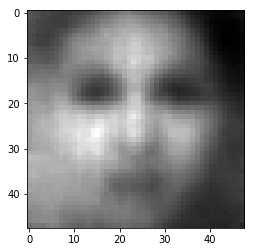

In [7]:

plt.imshow(trans_img_dataset[2].reshape((48,48)),cmap='gray')

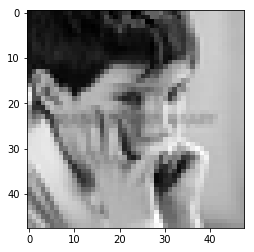

In [53]:
plt.imshow(X_train[3].reshape((48,48)), cmap ='gray')

In [9]:
print y_train[:20]

[0 0 2 4 6 2 4 3 3 2 0 6 6 6 3 5 3 2 6 4]


In [10]:
X_gen_   = trans_img_dataset.reshape((trans_img_dataset.shape[0], -1))
X_train_ = X_train.reshape((X_train.shape[0], -1))

print X_gen_.shape
print X_train_.shape

(32298, 2304)
(32298, 2304)


In [10]:
X_sub_1 = np.subtract(X_train_, X_gen_)

print X_sub_1.shape

(32298, 2304)


In [135]:
#np.save('X_train_substract_1',X_sub_1)

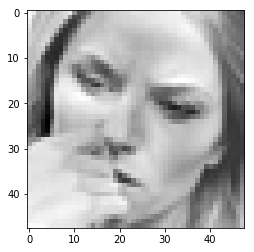

In [134]:
plt.imshow(X_sub_1[2].reshape((48,48)), cmap= 'gray')

In [11]:
from scipy import spatial 

X_gen_   = trans_img_dataset.reshape((trans_img_dataset.shape[0], -1))
X_train_ = X_train.reshape((X_train.shape[0], -1))

#from sklearn.metrics import pairwise

In [31]:
tem = []
for i in range(0, 32298):
    #alpha = 
    cos_dis =  spatial.distance.cosine(X_train_[i].astype('float32'), ## lower close to neutral 
                                        X_gen_[i].astype('float32'))
    if np.isnan(cos_dis) == True:
        tem.append(0.1)
    else:
        tem.append(cos_dis)

    

In [35]:
import numpy as np
a = np.asarray(tem)
#a[10]
a_avg = np.average(a)
a_std = np.std(a)

print a_avg
print a_std

0.108587651095
0.0616461680212


In [62]:
print a[15:20]

[ 0.07677597  0.18157208  0.10413402  0.10828418  0.14771414]


In [63]:
print y_train[15:20]

[5 3 2 6 4]


In [64]:
a.max()

0.9031367301940918

In [40]:
print a_avg - a_std
print a_avg + a_std

0.0469414830741
0.170233819116


In [45]:
np.

0.10830056667327881

In [44]:
y_train[11]

6

In [57]:
from keras.utils import to_categorical
y_train_ = to_categorical(y_train)
y_train_arousal = np.column_stack((y_train_, a))

In [65]:
#np.save('pseudo_arousal', a)


In [27]:

from scipy import spatial


X_gen_   = trans_img_dataset.reshape((trans_img_dataset.shape[0], -1))
X_train_ = X_train.reshape((X_train.shape[0], -1))

from sklearn.metrics import pairwise

#cos_matrix = pairwise.cosine_similarity(X_train_, X_gen_)
# to get the cosine distance between two dataset
tem = []

for i in range(0, 32298):
    #alpha = 
    cos_dis =  (1/spatial.distance.cosine(X_train_[i].astype('float32'), 
                                          X_gen_[i].astype('float32')))/10.
    if np.isnan(cos_dis) == True:
        tem.append(0.1)
    elif cos_dis >= 3:
        tem.append(3)     
    else:    
        tem.append(cos_dis)
    #tau_index = (1/cos_sim)/3
    #tem.append(cos_dis)



In [28]:
arousal_index = np.asarray(tem)

print arousal_index[11:20]
print y_train[11:20]
print arousal_index.max()
print arousal_index.min()

[1.19562349 0.52493088 2.87966496 0.71960005 1.3024909  0.55074547
 0.96030094 0.92349597 0.67698327]
[6 6 6 3 5 3 2 6 4]
3.0
0.1


In [29]:

def gumbel(*args):
    
    u = np.random.rand(*args)
    return -np.log(-np.log(u))

def softmax(x, axis=None):
    
    x = np.exp(x)
    return x/np.sum(x, axis=axis)

def gumbelsoftmax(logits, tau, N=10000):
    
    #d_1 = len(logits[0])
    d_0 = len(logits)
    return softmax((logits.reshape(d_0,1) + 
                    gumbel(d_0*N).reshape(d_0,N))/tau,axis=0)


In [30]:
from keras import utils

y_train_one = utils.to_categorical(y_train)

In [31]:
tem = [] #creating a holder
tau = arousal_index
for i in range(0, 32298): # iterate through all labels(32181 labels in y_train and y_test)
    tem_arr = gumbelsoftmax(y_train_one[i]*6, tau = arousal_index[i]).mean(axis = 1) #take N samples, then average over N 
    #tem_arr_new = np.expand_dims(tem_arr, axis = 0)
    tem = np.append(tem, tem_arr)

In [32]:
tem_1 = tem.reshape((32298,7))

In [35]:
#np.save('proactive_label_fer2013_v7_divide12_bound3.0*6', tem_1)

In [33]:
tem_1[11:20]

array([[0.01711471, 0.0173408 , 0.01684827, 0.01699625, 0.01706609,
        0.01712724, 0.89750664],
       [0.00365404, 0.00395003, 0.00403673, 0.00393268, 0.00331311,
        0.0040791 , 0.97703432],
       [0.07565505, 0.07529923, 0.07479619, 0.07548035, 0.07546192,
        0.07511861, 0.54818866],
       [0.00670218, 0.00531131, 0.0059599 , 0.96394802, 0.00668828,
        0.00624529, 0.00514502],
       [0.02056025, 0.020311  , 0.02117048, 0.02109734, 0.02070722,
        0.87530067, 0.02085305],
       [0.00455788, 0.00427624, 0.00347659, 0.9757967 , 0.00401803,
        0.00364711, 0.00422745],
       [0.00984475, 0.01047101, 0.93972577, 0.01009142, 0.01011502,
        0.00989561, 0.00985642],
       [0.01000034, 0.01020947, 0.00951146, 0.00971479, 0.00974413,
        0.00974418, 0.94107564],
       [0.00479245, 0.00545444, 0.00463943, 0.00618198, 0.96703845,
        0.00605535, 0.0058379 ]])

In [34]:
print tem_1.shape

(32298, 7)


In [19]:
y_train[1]

0

In [15]:
from keras import utils

#label_smooth = utils.

In [53]:
test = 1/spatial.distance.cosine(X_train_[2].astype('float32'), X_gen_[2].astype('float32'))
print test

18.6355947829


In [201]:
(1/0.24)/2


2.0833333333333335

In [136]:
from skimage.measure import compare_ssim as ssim
X_gen_   = trans_img.flatten()
ssim_ = ssim(X_train_[4].astype('float32'), X_gen_)

print ssim_

0.309122809914


In [144]:
y_train[13]

6

In [5]:
import numpy as np
from skimage import color, data, restoration
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.restoration import denoise_wavelet

psf = np.ones((5,5)) / 25.
from scipy import ndimage
from scipy.signal import convolve2d

denoise_kwargs = dict(multichannel=False, convert2ycbcr=False, wavelet='db1')

img = X_gen[14].reshape((48,48))
#im_bayescs = cycle_spin(noisy, func=denoise_wavelet, max_shifts=5,
                            #func_kw=denoise_kwargs, multichannel=True)

#sigma_est = np.mean(estimate_sigma(img, multichannel=True))
#patch_kw = dict(patch_size=3,      # 5x5 patches
               # patch_distance=6,  # 13x13 search area
                # multichannel=False)


#sigma_est = np.mean(estimate_sigma(img, multichannel=False))
#img = convolve2d(img, psf, 'same')
#img += 0.1 * img.std() * np.random.standard_normal(img.shape)

#denoise_fast = denoise_nl_means(img, h=0.8 * sigma_est, fast_mode=True,
                                #**patch_kw)
#deconvolved_imgs = restoration.wiener(img, psf, 10, clip=False)
#denoise_img = denoise_wavelet(img,convert2ycbcr=True,
                #multichannel = False)
#gauss_denoised = ndimage.median_filter(X_gen[14], 2)

#denoise_img_2 = denoise_bilateral(img, sigma_color=0.05, sigma_spatial=50,
                #multichannel=False)

#denoise_img_3 = denoise_tv_chambolle(img, weight=0.0001, multichannel=False)



In [2]:
import numpy as np
import scipy.stats as st

def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""

    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

def disk_kernel(radius):
    
    kern = np.zeros((2*radius+1, 2*radius+1))
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    kern[mask] = 1
    return kern

In [91]:
import skimage

psf_gau = gkern(5,12)
psf_dis = disk_kernel(2)
deconv_img_1 = restoration.richardson_lucy(img, psf_gau, iterations=100)
deconv_img_2 = restoration.wiener(img, psf_gau, 0.05, clip= False)
#deconv_img_3 = skimage.filters.median(img, selem = circle)

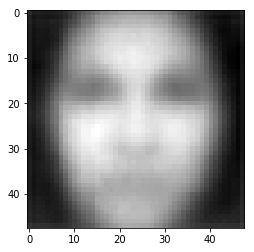

In [92]:
plt.imshow(deconv_img_1.reshape((48,48)),cmap='gray')